In [67]:
%load_ext autoreload
%autoreload 2
import os
import sys
from pathlib import Path
import networkx as nx
import pandas as pd
import numpy as np
sys.path.insert(0, Path.cwd().absolute())

BASE_DIR = (Path.cwd()).parent

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from flow_assignment.flow_assignment import FlowAssignment
from geoprocessing.faf_zone_network import FafZoneNetwork, link_weights
from flow_assignment.mc_flow_assignment import sample_flows
import geopandas as gpd

In [121]:
SIMPLE_NET = False #(421, 423, 341, 342 )
MONTE_CARLO = True
MC_ITER_N = 500
COLUMN = 'thousand tons in 2050'
NORMAL_DIST = False

# Validations
if SIMPLE_NET:
  MONTE_CARLO = False
  

131015

In [117]:
naRailNodesDf = gpd.read_file( BASE_DIR / "inputs/NTAD_North_American_Rail_Network_Nodes")
naRailLinesDf = gpd.read_file( BASE_DIR / "inputs/NTAD_North_American_Rail_Network_Lines")
fafZonesDf = gpd.read_file( BASE_DIR / "inputs/2017_CFS_Metro_Areas_with_FAF").to_crs(4326)
faf_flows = pd.read_csv(Path.cwd().parent / 'inputs/faf_freight_flow.csv' )
fzn = FafZoneNetwork(naRailNodesDf, naRailLinesDf, fafZonesDf).setInputDfColType()

if SIMPLE_NET:
  fzn.fafZonesDf = fzn.fafZonesDf.loc[fzn.fafZonesDf.FAF_Zone.isin(SIMPLE_NET)]
  faf_flows = pd.DataFrame([
    [ 421, 423, 10],
    [421,341, 77],
    [342, 423, 96]
  ], columns=['dms_orig', 'dms_dest', COLUMN])
  display(SIMPLE_NET)
  display(faf_flows)
fzn.network_weight_fn = link_weights
railnet = fzn.createNetwork()

/home/nathanczh/ctsm/faf_flow_assignment/src/geoprocessing/faf_zone_network.py:47: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fafZoneNodesDf.geometry = fafZoneNodesDf.centroid


Preprocessed


/home/nathanczh/ctsm/faf_flow_assignment/src/geoprocessing/faf_zone_network.py:147: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df['distance'] = df['geometry_fr'].distance(df['geometry_to'])


In [119]:

fa = FlowAssignment(railnet)

railnet_flows = fa.run(faf_flows, SUM_COLUMN=COLUMN) # For comparison, if Monte Carlo mode
if not MONTE_CARLO:
  fzn.apply_flows(railnet_flows.to_dict())

if MONTE_CARLO:

  monte_railnet_flows = []
  monte_inputs = []
  for i in range(MC_ITER_N):
    iteration_inputs = sample_flows(faf_flows, COLUMN, distribution='normal' if NORMAL_DIST else 'triangular')
    monte_inputs.append(iteration_inputs)
    faf_flows['input_flows'] = iteration_inputs
    iteration_flow = fa.run(faf_flows, SUM_COLUMN='input_flows')
    monte_railnet_flows.append(iteration_flow)
  monte_railnet_flows = pd.concat(monte_railnet_flows, axis=1)
  monte_railnet_flows.columns=range(MC_ITER_N)
  fzn.fafZoneLinksDf['flows'] = monte_railnet_flows.mean(axis=1)
  fzn.fafZoneLinksDf['flow_covs'] = monte_railnet_flows.std(axis=1) / monte_railnet_flows.mean(axis=1)
  railnet_flows.index = railnet_flows.index.set_names({'seg_start':'FAF_Zone_fr', 'seg_end':'FAF_Zone_to'})
  fzn.fafZoneLinksDf['flow_df'] = (fzn.fafZoneLinksDf['flows'] - railnet_flows).abs()
  fzn.fafZoneLinksDf['flow_df_percent'] = fzn.fafZoneLinksDf['flow_df'] / railnet_flows

,FAF_Zone_1_fr,FAF_Zone_1_to,flows,flow_covs,flow_df,flow_df_percent
0,Arkansas,Remainder of Missouri,145240.792,0.028293,31.792,0.000219
1,Remainder of Minnesota,North Dakota,142948.978,0.048032,79.022,0.000552
2,Remainder of Illinois,Iowa,133844.194,0.044989,9.806,0.000073
3,Arkansas,Remainder of Texas,114675.082,0.032492,13.082,0.000114
4,Remainder of Kentucky,Remainder of Tennessee,103817.500,0.034986,88.500,0.000853
...,...,...,...,...,...,...
250,"Sacramento-Roseville, CA CFS Area","San Jose-San Francisco-Oakland, CA CFS Area",0.000,NaN,0.000,NaN
251,"Cincinnati-Wilmington-Maysville, OH-KY-IN CFS...","Cincinnati-Wilmington-Maysville, OH-KY-IN CFS...",0.000,NaN,0.000,NaN
252,"New York-Newark, NY-NJ-CT-PA CFS Area (NJ Part)","New York-Newark, NY-NJ-CT-PA CFS Area (PA Part)",0.000,NaN,0.000,NaN
253,"Columbus-Marion-Zanesville, OH CFS Area","Dayton-Springfield-Sidney, OH CFS Area",0.000,NaN,0.000,NaN


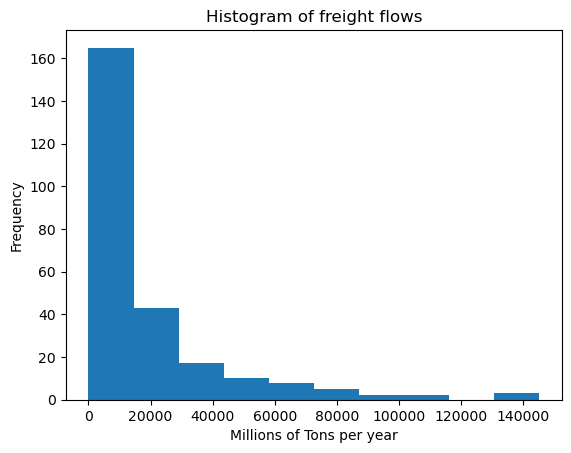

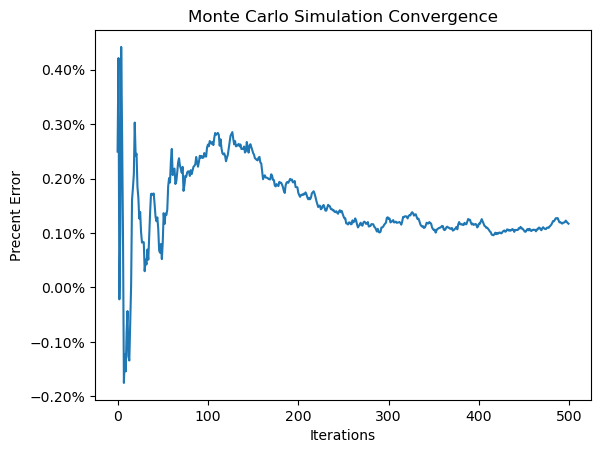

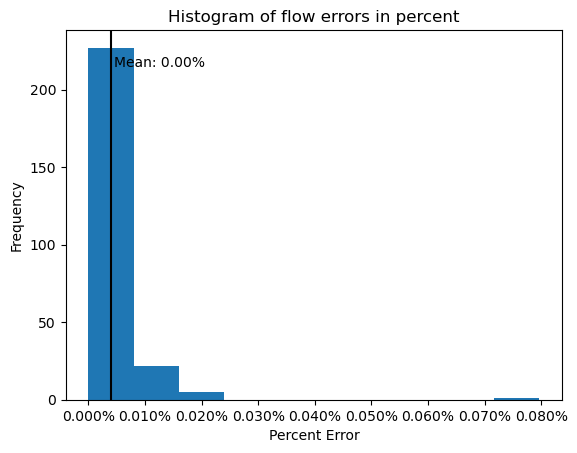

In [120]:
import matplotlib.pyplot as plt

import folium
import branca.colormap as cm
from IPython.display import display


min_lat=24.7433195
max_lat=49.3457868
min_lon=-124.7844079
max_lon=-66.9513812


m = folium.Map(
  max_bounds=True,
  location=[42, -95],
  zoom_start=4,
  min_zoom=4,
  tiles='OpenStreetMap',
  max_lat=max_lat,
  min_lon=min_lon,
  max_lon=max_lon,
  min_lat=min_lat
)

# m.fit_bounds([[min_lat, min_lon], [max_lat, max_lon]])

wmax = fzn.fafZoneLinksDf['flows'].max()
wmin = fzn.fafZoneLinksDf['flows'].min()
def norm_w(feature):
  return (feature['properties']['flows'] - wmin)/(wmax-wmin)

lineWeightMax = 4
lineWeightMin = 0.75

fzn.fafZoneLinksDf[['FAF_Zone_1_fr', 'FAF_Zone_1_to', 'flows', 'geometry']].explore(
  m=m,
  column='flows',
  style_kwds={
    'style_function': lambda feature: {
      'color': cm.linear.plasma(norm_w(feature)),
      'weight': norm_w(feature) * (lineWeightMax - lineWeightMin) + lineWeightMin
    }
  }
)

fzn.fafZoneNodesDf[['FAF_Zone_1', 'geometry']].explore(
  m=m,
  color='black'
)

folium.LayerControl().add_to(m)
display(m)
display(fzn.fafZoneLinksDf.sort_values('flows', axis=0, ascending=False).reset_index()[
  ['FAF_Zone_1_fr', 'FAF_Zone_1_to', 'flows'] + (['flow_covs', 'flow_df', 'flow_df_percent'] if MONTE_CARLO else [])
])
fzn.fafZoneLinksDf['flows'].plot(
  kind='hist',
  title='Histogram of freight flows',
  xlabel='Millions of Tons per year'
)
plt.show()

if MONTE_CARLO:
  from matplotlib.ticker import PercentFormatter

  plot = monte_railnet_flows.sub(railnet_flows, axis=0).div(railnet_flows, axis=0).mul(100, axis=0).T.expanding().mean().mean(axis=1).plot(
    title='Monte Carlo Simulation Convergence',
    xlabel='Iterations',
    ylabel='Precent Error'
  )
  plot.yaxis.set_major_formatter(PercentFormatter())
  plt.show()

  fzn.fafZoneLinksDf.loc[~np.isfinite(fzn.fafZoneLinksDf.flow_df_percent), 'flow_df_percent'] = 0
  plot = fzn.fafZoneLinksDf.flow_df_percent.plot(
    kind='hist',
    title='Histogram of flow errors in percent',
    xlabel='Percent Error'
  )
  mean_error = fzn.fafZoneLinksDf.flow_df_percent.mean()
  plt.axvline(mean_error, color='k')
  plot.xaxis.set_major_formatter(PercentFormatter())
  
  min_ylim, max_ylim = plt.ylim()
  plt.text(mean_error * 1.1, max_ylim*0.9, 'Mean: {:.2f}%'.format(mean_error))
  plt.show()